# ACCESS-OM2 0.1$^\circ$

This notebook documents our first attempt to run and analyse output from the [ACCESS-OM2 Pre-release](https://github.com/OceansAus/access-om2), implemented at 0.1°.


## Current Status


|** Run Name** | **Forcing** | ** Run ** | ** Status **|
|--------------|---------|-------------------------------------------------|-------------|


The following (from [here](https://stackoverflow.com/questions/41641205/how-to-avoid-output-into-scrollable-frames-in-jupyter-notebook)) avoids scroll boxes for long output. 
Must be the first cell.
Could also use [autoscroll](https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/autoscroll).

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import seaborn as sns
# sns.set_style('whitegrid', {'grid.color': '.9',
#                            'legend.frameon': True})

In [5]:
# client = cc.start_cluster()
# client

In [6]:
cc.build_index()

Files found but not yet indexed: 0
No new .nc files found.


True

## Experiments

In [7]:
# get a full list of relevant experiments
configuration = 'access-om2-01'
# expts = cc.get_experiments(configuration)
expts = ['01deg_jra55v13_ryf8485_spinup6']
expts.sort()
# expts.append('mom025_jra_ryf9091') # MOM-SIS as a reference
display(expts)
#cc.summary_md(configuration,expts)

# This subset of cases are the important ones
esub = expts.copy()
# esub.pop(6)
# esub.pop(5)
# esub.pop(4)
# esub.pop(3)
# esub.pop(2)
# esub.pop(1)
# esub.pop(0)
display(esub)
# cc.summary_md(configuration,esub)

['01deg_jra55v13_ryf8485_spinup6']

['01deg_jra55v13_ryf8485_spinup6']

## Wind Stress
Just a simple plot showing zonally averaged zonal wind stress from each case.


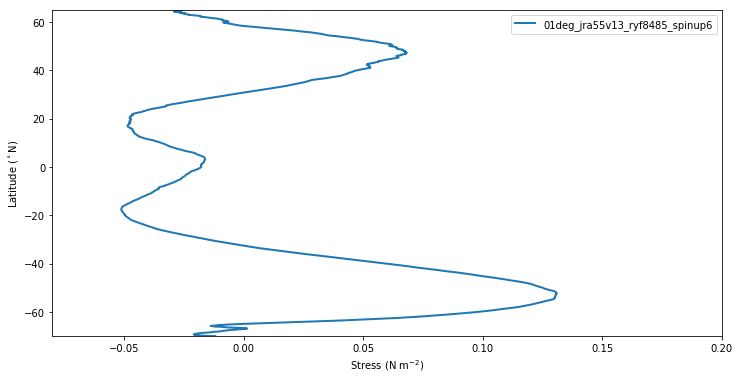

In [8]:
cc.plots.wind_stress(esub)

## Ocean Scalars
The following series of plots shows global timeseries of key metrics.

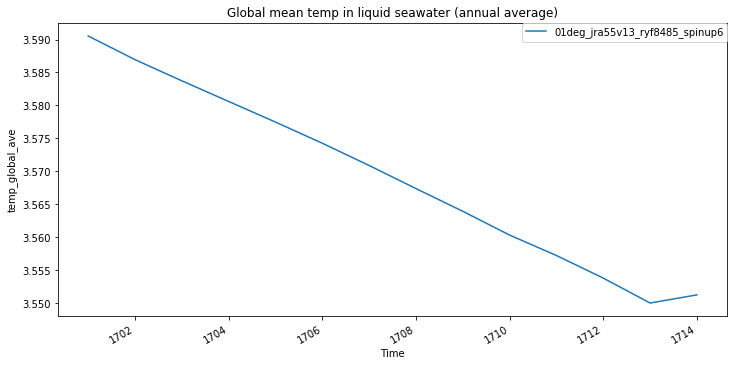

In [9]:
#cc.diagnostics.annual_scalar.clear()
cc.plots.annual_scalar(esub, 'temp_global_ave')

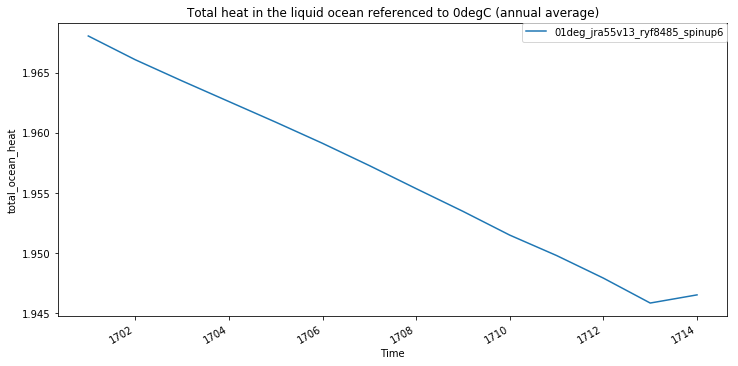

In [10]:
cc.plots.annual_scalar(esub, 'total_ocean_heat')

Average flux [Wm^-2]


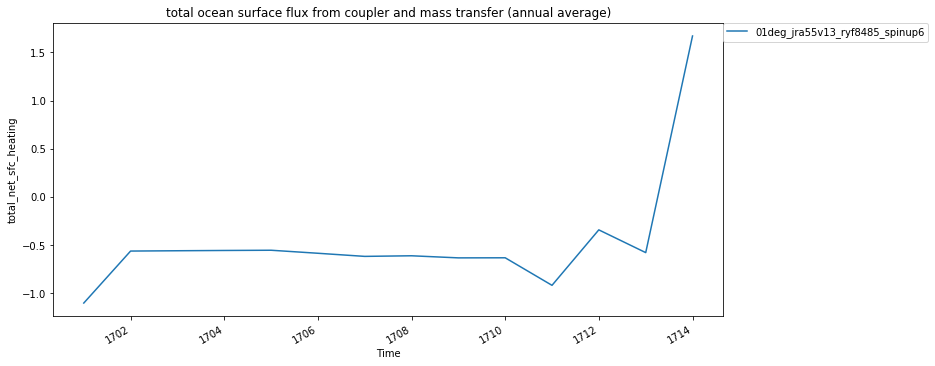

In [11]:
cc.plots.annual_scalar(esub, 'total_net_sfc_heating')

# also check that added heat accounts for change in heat
print("Average flux [Wm^-2]")
for expt in esub[-2:-1]:
    annual_average = cc.diagnostics.annual_scalar(expt, 'total_net_sfc_heating')*1e15 # in W
    heat = cc.diagnostics.annual_scalar(expt, 'total_ocean_heat')*1e25 # in J
    heat_change = heat[-1] - heat[0]
    annual_heat_change = annual_average*365*24*60*60
    annual_heat_change_avg = np.mean(annual_heat_change[-20:]) # last 20 yr at most
# Convert to Wm^-2. Ocean surface area from acccess-om2.out:
# Surface area of k=1 tracer cells                  =  3.62711632314368000E+14 m^2
    flux = np.mean(annual_average[-20:])/3.62711632314368000E+14   
    print("%s %e %e %e" % (expt, flux, heat[-1] - heat[0], np.sum(annual_heat_change)))

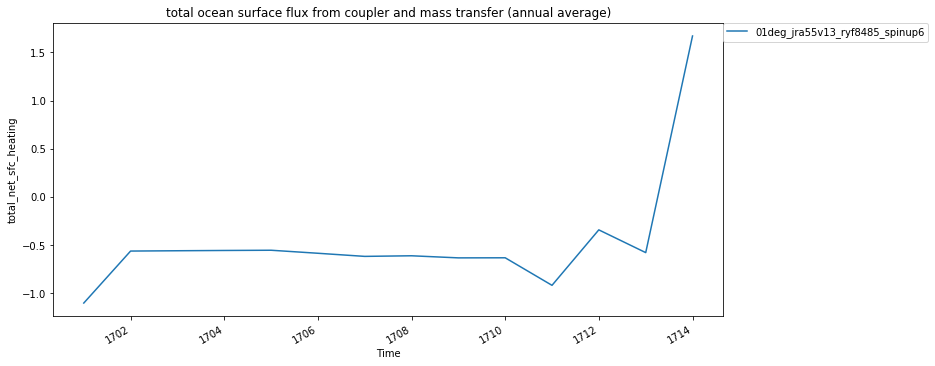

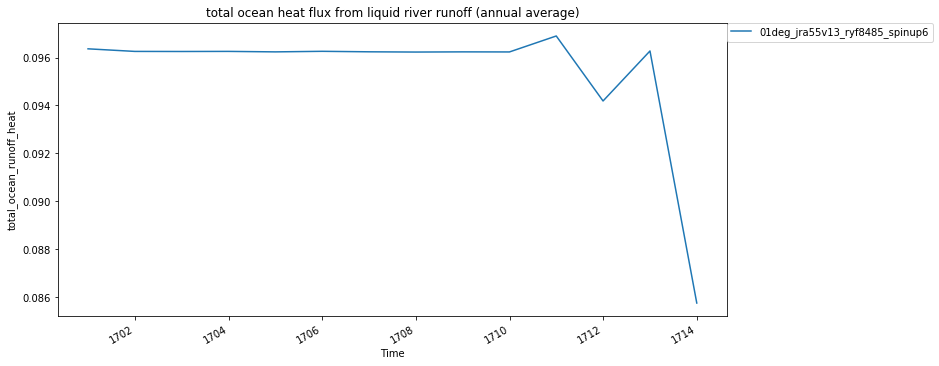

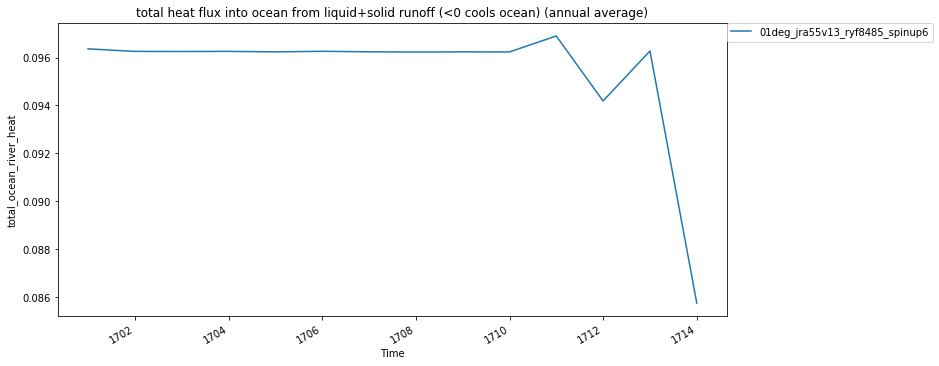

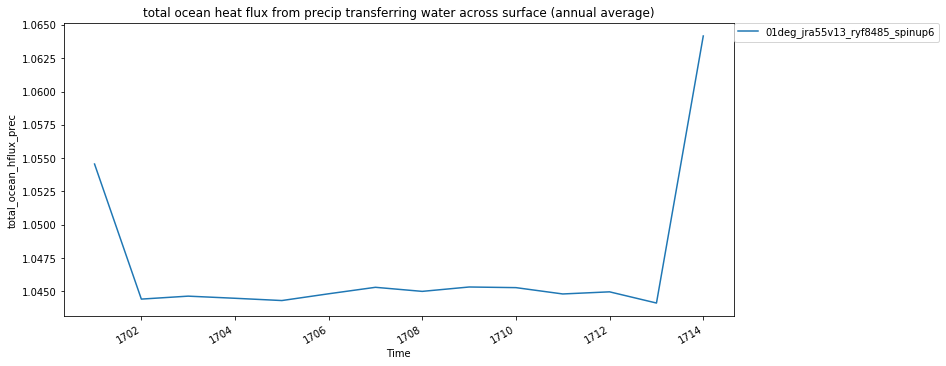

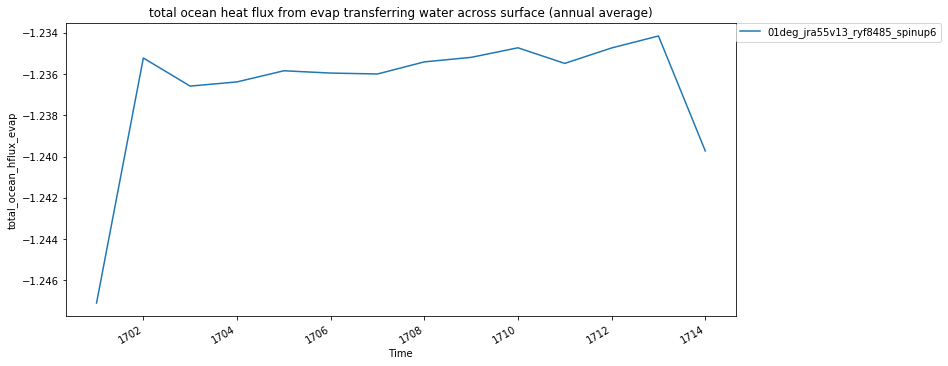

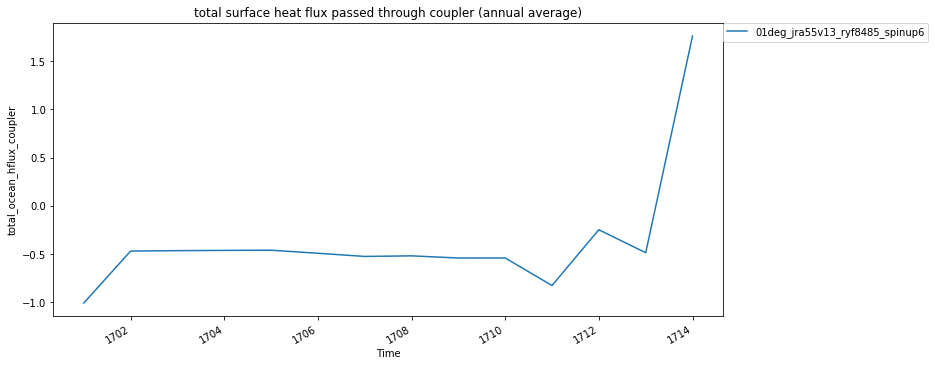

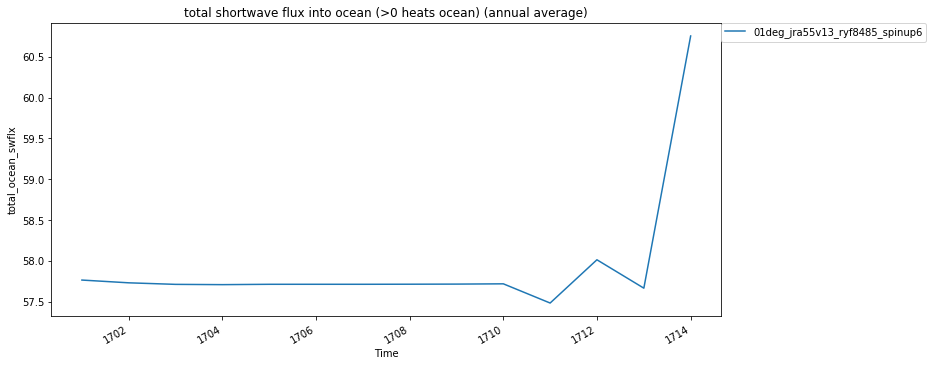

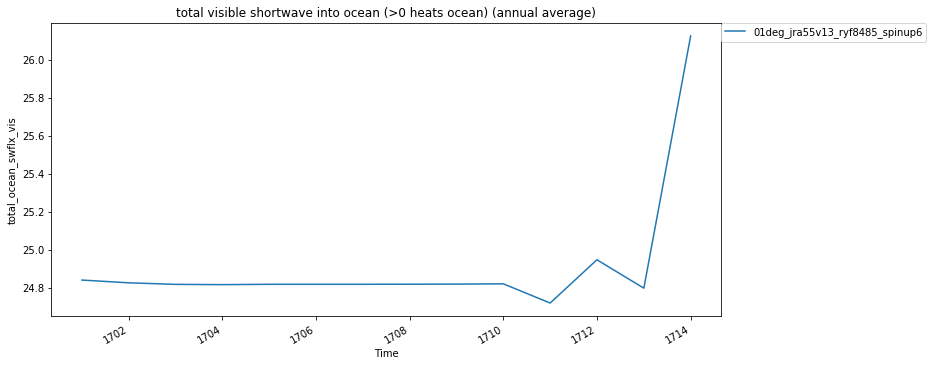

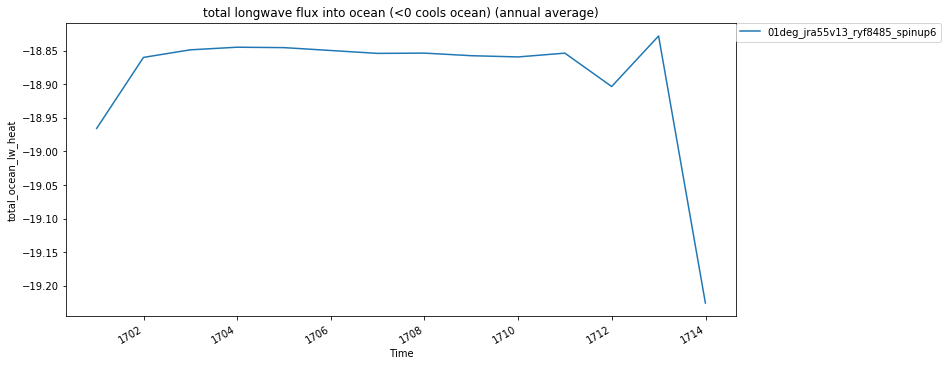

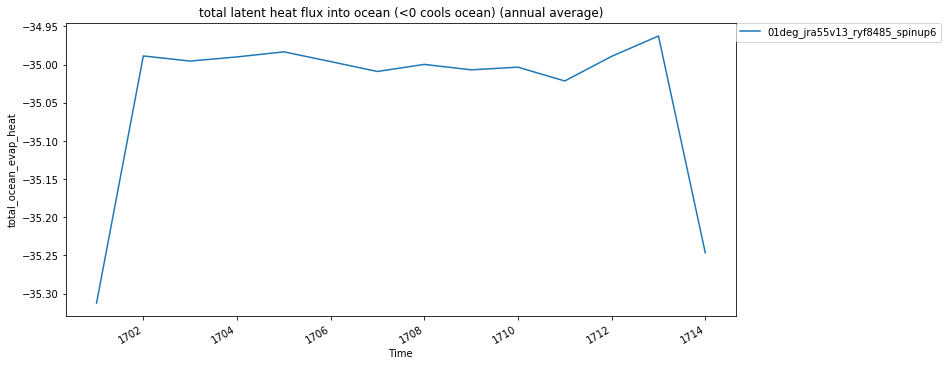

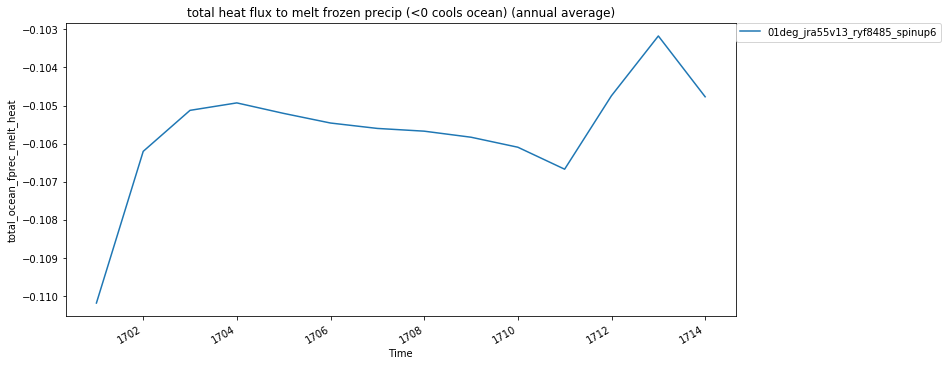

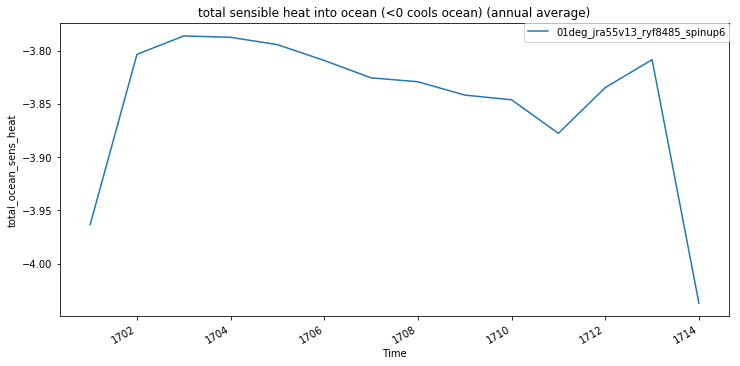

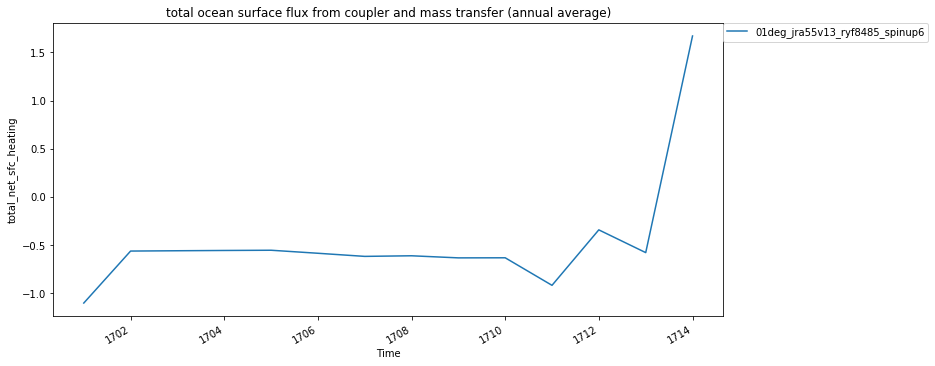

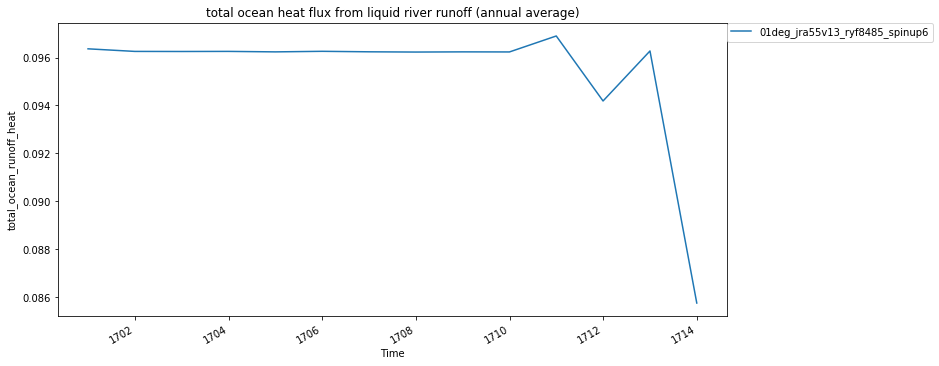

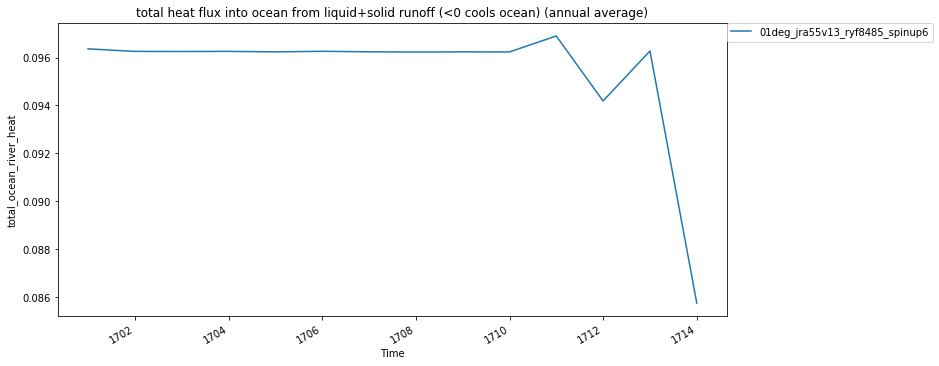

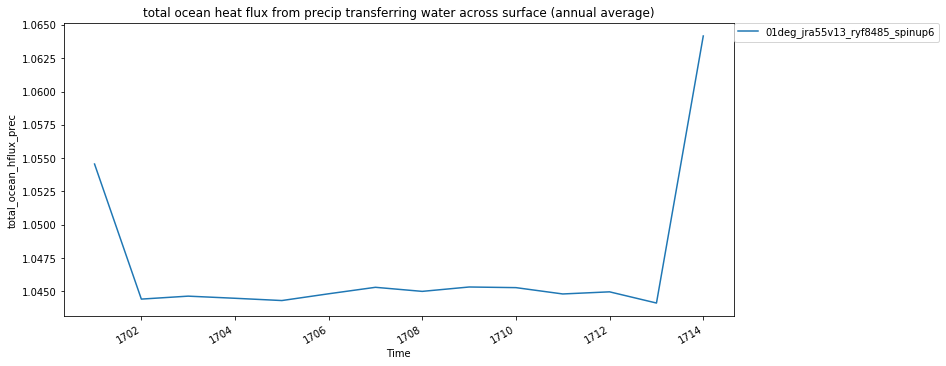

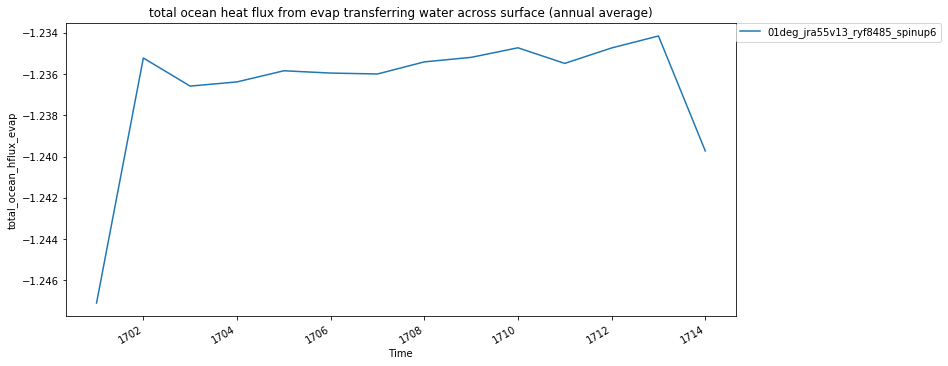

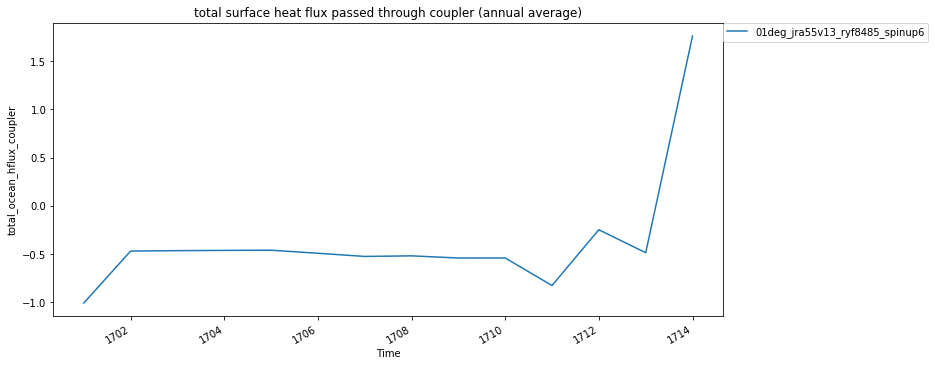

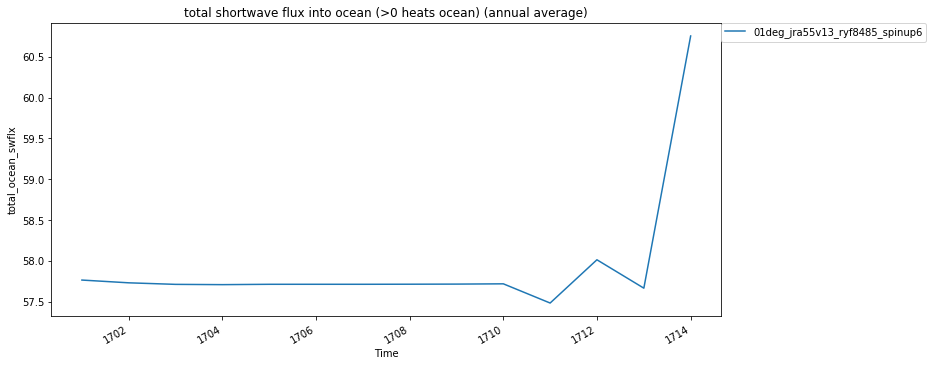

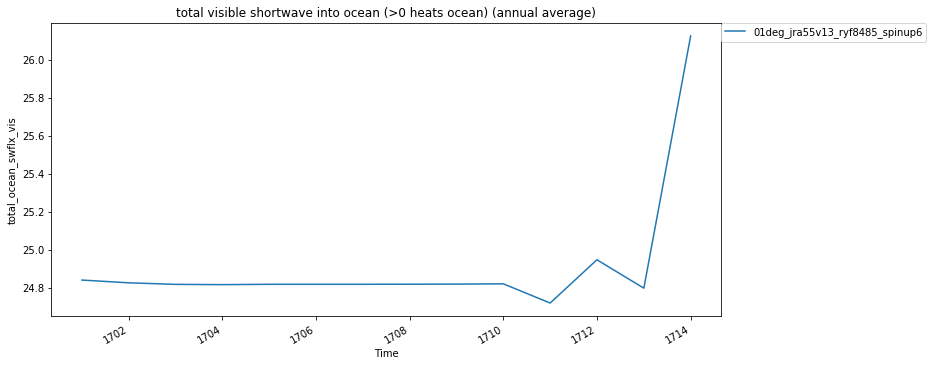

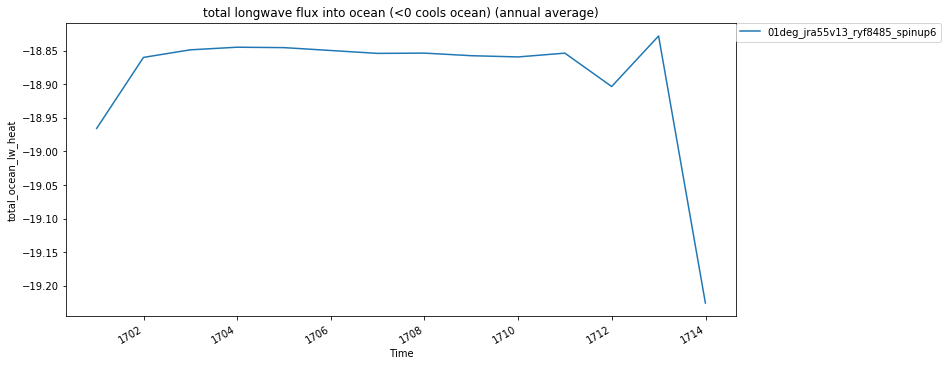

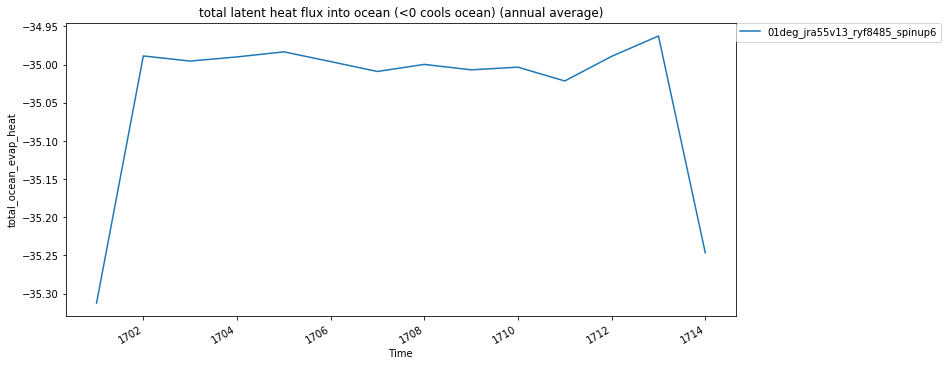

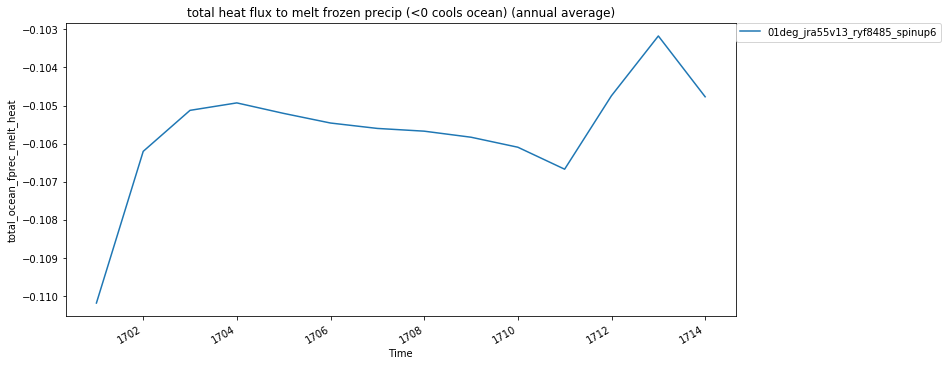

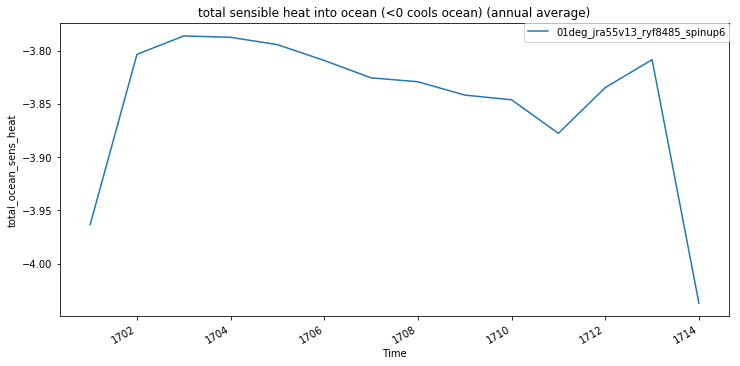

In [15]:
heatvars=['total_net_sfc_heating', 
          'total_ocean_runoff_heat', 
#           'total_ocean_calving_heat', 
          'total_ocean_river_heat', 
          'total_ocean_hflux_prec', 
          'total_ocean_hflux_evap', 
          'total_ocean_hflux_coupler', 
          'total_ocean_swflx', 
          'total_ocean_swflx_vis', 
          'total_ocean_lw_heat', 
          'total_ocean_evap_heat', 
          'total_ocean_fprec_melt_heat', 
#           'total_ocean_calving_melt_heat', 
          'total_ocean_sens_heat']

cc.plots.annual_scalar(esub[0], heatvars)

for hv in heatvars:
    cc.plots.annual_scalar(esub[0], hv)

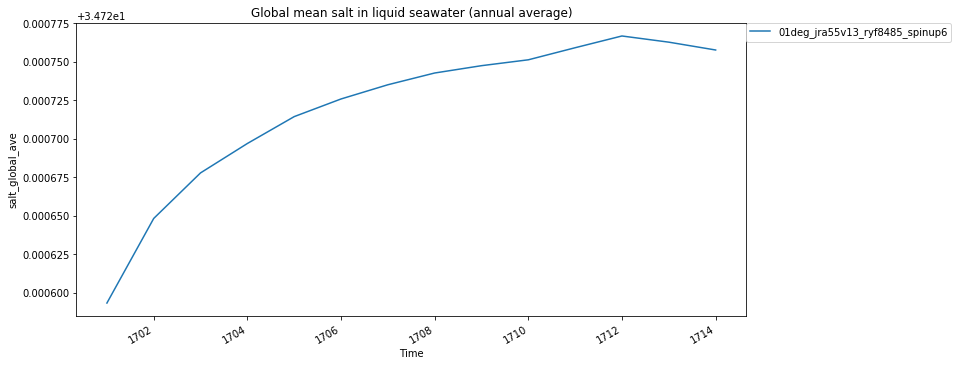

In [16]:
cc.plots.annual_scalar(esub, 'salt_global_ave')

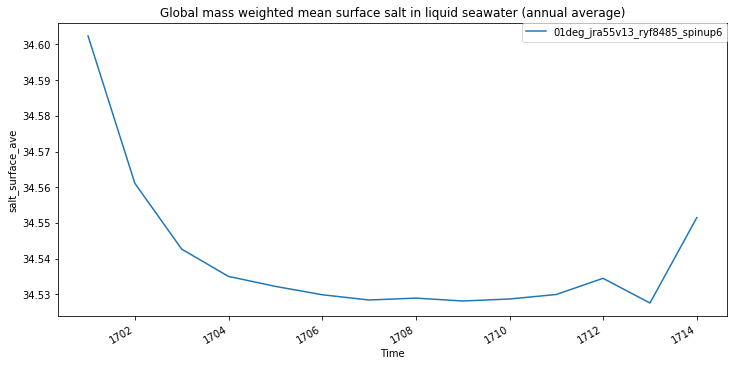

In [17]:
cc.plots.annual_scalar(esub, 'salt_surface_ave')

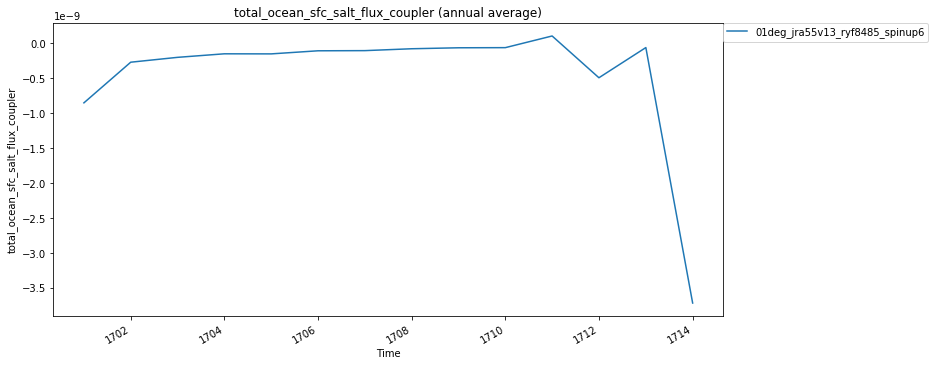

In [18]:
cc.plots.annual_scalar(esub, 'total_ocean_sfc_salt_flux_coupler')

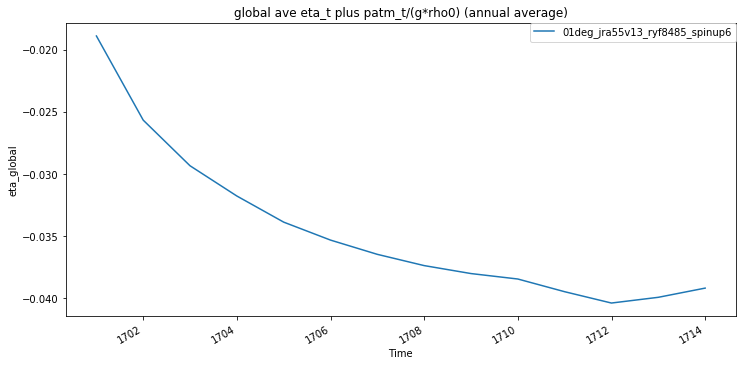

In [19]:
cc.plots.annual_scalar(esub, 'eta_global')

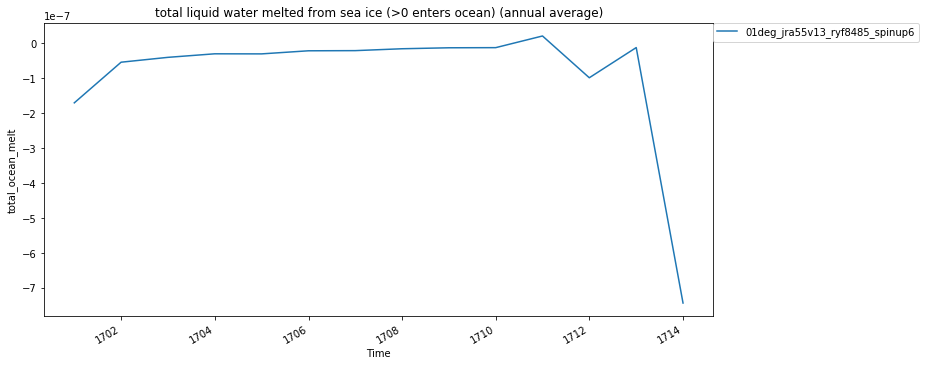

In [20]:
cc.plots.annual_scalar(esub, 'total_ocean_melt')

In [21]:
variables = cc.netcdf_index.get_scalar_variables(configuration)

In [22]:
from ipywidgets import widgets, interact, interactive, fixed

def myplot(expts, variable):
    plt.figure(figsize=(10,8))
    cc.plots.annual_scalar(expts, variable)
    plt.show()
    
interactive(myplot,
            expts=fixed(expts),
            variable=widgets.Dropdown(options=variables, description='Scalar Variable:'))

interactive(children=(Dropdown(description='Scalar Variable:', options=('ke_tot', 'pe_tot', 'temp_global_ave', 'salt_global_ave', 'rhoave', 'temp_surface_ave', 'salt_surface_ave', 'total_ocean_salt', 'total_ocean_heat', 'eta_global', 'total_volume_seawater', 'total_ocean_sfc_salt_flux_coupler', 'total_net_sfc_heating', 'total_ocean_pme_river', 'total_ocean_river', 'total_ocean_runoff', 'total_ocean_calving', 'total_ocean_melt', 'total_ocean_evap', 'total_ocean_lprec', 'total_ocean_fprec', 'total_ocean_runoff_heat', 'total_ocean_calving_heat', 'total_ocean_river_heat', 'total_ocean_hflux_prec', 'total_ocean_hflux_evap', 'total_ocean_hflux_coupler', 'total_ocean_swflx', 'total_ocean_swflx_vis', 'total_ocean_lw_heat', 'total_ocean_evap_heat', 'total_ocean_fprec_melt_heat', 'total_ocean_calving_melt_heat', 'total_ocean_sens_heat'), value='ke_tot'), Output()), _dom_classes=('widget-interact',))

## Drake Passage Transport


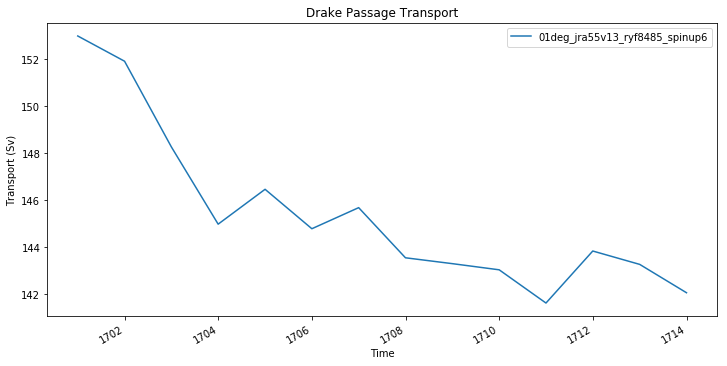

In [23]:
cc.plots.drake_passage(esub)

## Overturning circulation
First we plot mean overturning for the final decade of the simulation.
Then we look at overturning timeseries.

** This calculation also needs us to treat landmasked tiles.**

In [24]:
# def calc_psi_avg(expt):
#     print('Calculating {} psi_avg'.format(expt))
    
#     #op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

#     psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
#                         #op=op,
#                         chunks={'potrho': None}, time_units = 'days since 1900-01-01', n=10)
        
#     if psi.units == 'kg/s':
#         print('WARNING: Changing units for ', expt)
#         psi = psi*1.0e-9

#     psi_avg = psi.sum('grid_xt_ocean').cumsum('potrho').mean('time')
#     psi_avg = psi_avg.compute()
    
#     return psi_avg

In [25]:
# def plot_psi(psi_avg, expt, clev=np.arange(-20,20,2)):

#     plt.contourf(psi_avg.grid_yu_ocean, 
#                  psi_avg.potrho, 
#                  psi_avg, 
#                  cmap=plt.cm.PiYG,levels=clev,extend='both')
#     cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#     cb.ax.set_xlabel('Sv')
#     plt.contour(psi_avg.grid_yu_ocean, 
#                 psi_avg.potrho, 
#                 psi_avg, levels=clev, colors='k', linewidths=0.25)
#     plt.contour(psi_avg.grid_yu_ocean,
#                 psi_avg.potrho, psi_avg,
#                 levels=[0.0,], colors='k', linewidths=0.5)
#     plt.gca().invert_yaxis()
    
#     plt.ylim((1037.5,1034))
#     plt.ylabel('Potential Density (kg m$^{-3}$)')
#     plt.xlabel('Latitude ($^\circ$N)')
#     plt.xlim([-75,85])
#     plt.title('Overturning in %s' % expt)

In [26]:
# for e in esub: 
#     plt.figure(figsize=(8, 6)) 
#     psi_avg = calc_psi_avg(e)
#     plot_psi(psi_avg, e)

In [28]:
def calc_psi_time(expt): # TODO: cache these results?
    print('Calculating {} timeseries of transport '.format(expt))
    
    #op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          #op=op,
                          chunks={'potrho': None},
                          time_units = 'days since 1900-01-01')
    
    if psi.units == 'kg/s':
        print('WARNING: Changing units for ', expt)
        psi = psi*1.0e-9
    
    psi_sum = psi.sum('grid_xt_ocean').cumsum('potrho')
    
    psi_aabw = psi_sum[:,60:,230].min('potrho').resample('3A',dim='time')
    psi_aabw = psi_aabw.compute()
    psi_amoc = psi_sum[:,60:,605].max('potrho').resample('3A',dim='time')
    psi_amoc = psi_amoc.compute()
    psi_amoc_south = psi_sum[:,60:,345].max('potrho').resample('3A',dim='time')
    psi_amoc_south = psi_amoc_south.compute()
    
    return psi_aabw, psi_amoc, psi_amoc_south

Calculating 01deg_jra55v13_ryf8485_spinup6 timeseries of transport 


HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=132), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="3A").mean() 
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/ipykernel/__main__.py:19: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="3A").mean() 
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="3A").mean() 


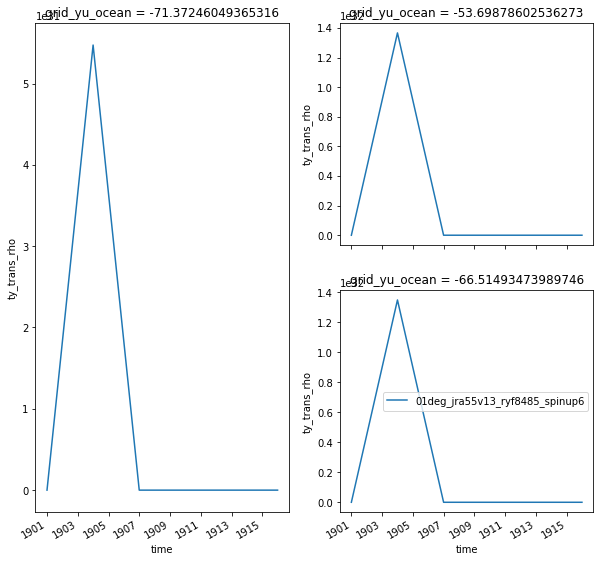

In [29]:
plt.figure(figsize=(10, 10)) 
for e in esub: 
    psi_aabw,psi_amoc,psi_amoc_south = calc_psi_time(e)
        
    plt.subplot(121)
    psi_aabw.plot()
    plt.subplot(222)
    psi_amoc.plot()
    plt.subplot(224)
    psi_amoc_south.plot(label=e)
    
plt.legend()

## Surface Temperature
Let's look at mean surface temperature averaged over the last decade. We will show the MOM-SIS case first, then look at differences between ACCESS-OM2 cases and MOM-SIS.

In [30]:
cc.plots.sea_surface_temperature(esub)

HBox(children=(IntProgress(value=0, description='experiments', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=12), HTML(value='')))

ValueError: operands could not be broadcast together with shapes (2700, 3600) (300, 360)

## Surface Salinity
Let's look at mean surface salinity averaged over the last decade. We will show the MOM-SIS case first, then look at differences between ACCESS-OM2 cases and MOM-SIS.

In [ ]:
cc.plots.sea_surface_salinity(esub)

# Zonal mean transects

In [ ]:
cc.plots.zonal_mean(esub,'temp',n=10)

In [ ]:
cc.plots.zonal_mean(esub,'salt',n=10)

## Sea Ice
This part will plot the sea ice extent, compared with obs.

**Currently, only plots MOM cases - still working on CICE output.**

In [ ]:
# Assume all files have same grid
#area_t_south = get_nc_variable(e,'ocean_grid.nc','area_t').sel(yt_ocean=slice(-90,-30)).values
#area_t_north = get_nc_variable(e,'ocean_grid.nc','area_t').sel(yt_ocean=slice(30,90)).values
GridFile = '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output000/ocean_grid.nc'
dsg = xr.open_dataset(GridFile, decode_times=False, engine='netcdf4')
area_t_south = dsg.area_t.sel(yt_ocean=slice(-90,-30)).values
area_t_north = dsg.area_t.sel(yt_ocean=slice(30,90)).values

## Doing MOM case
e = expts[-1]
plt.figure(figsize=(12,8))
plt.subplot(121)
ice_area_south = get_nc_variable(e,'ice_month.nc','EXT',
                               time_units='days since 1900-01-01').sel(yt=slice(-90,-30)).groupby('time.month').mean('time')*area_t_south/1.0e6
ice_area_south.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)

plt.subplot(122)    
ice_area_north = get_nc_variable(e,'ice_month.nc','EXT',
                               time_units='days since 1900-01-01').sel(yt=slice(30,90)).groupby('time.month').mean('time')*area_t_north/1.0e6
ice_area_north.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)

# sea ice observation data here:
ObsDirExt = '/g/data/v45/akm157/data/NSIDC/NOAA_G02135_extent_monthly/'
obsExtSHFileList = glob(os.path.join(ObsDirExt, 'sh/*.csv'))
obsExtSHFileList.sort()
obsExtNHFileList = glob(os.path.join(ObsDirExt, 'nh/*.csv'))
obsExtNHFileList.sort()

## Now for ACCESS case


## obs extent:
# just take 20 years 1979-1998 where available:
SH_extent_climatology_obs = np.zeros(12)
import csv
for month in range(12):
    n_years = 0
    #print('opening '+obsExtSHFileList[month])
    with open(obsExtSHFileList[month]) as csvfile:
        reader = csv.reader(csvfile)
        rownum = 0
        for row in reader:
            if (rownum > 0 and float(row[-2])>0 and float(row[0])>1978 \
                and float(row[0])<1999):
                SH_extent_climatology_obs[month] += float(row[-2])
                n_years = n_years + 1
            rownum = rownum + 1
    SH_extent_climatology_obs[month] = SH_extent_climatology_obs[month] / n_years

NH_extent_climatology_obs = np.zeros(12)
import csv
for month in range(12):
    n_years = 0
    #print('opening '+obsExtNHFileList[month])
    with open(obsExtNHFileList[month]) as csvfile:
        reader = csv.reader(csvfile)
        rownum = 0
        for row in reader:
            if (rownum > 0 and float(row[-2])>0 and float(row[0])>1978 \
                and float(row[0])<1999):
                NH_extent_climatology_obs[month] += float(row[-2])
                n_years = n_years + 1
            rownum = rownum + 1
    NH_extent_climatology_obs[month] = NH_extent_climatology_obs[month] / n_years

# plot northern:
plt.subplot(122)
plt.plot(np.arange(12)+1,NH_extent_climatology_obs*1e6,'k--',linewidth=2,label='obs')
plt.title('NH sea ice extent')
plt.legend()
#plt.ylabel(r'Sea ice extent (10$^{12}$m$^2$)')
#plt.title('Arctic extent')
#plt.show()

# plot southern:
plt.subplot(121)
plt.plot(np.arange(12)+1,SH_extent_climatology_obs*1e6,'k--',linewidth=2,label='obs')
plt.title('SH sea ice extent')
#plt.ylabel(r'Sea ice extent (10$^{12}$m$^2$)')
#plt.title('Antarctic extent')
#plt.show()


In [ ]:

ice_area_south = get_nc_variable(e,'iceh*-01.nc','aice')#.sel(yt=slice(-90,-30)).mean('time')*area_t_south/1.0e6
ice_area_south.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)
